In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aravsood7_sentiment_analysis_labelled_financial_news_data_path = kagglehub.dataset_download('aravsood7/sentiment-analysis-labelled-financial-news-data')

print('Data source import complete.')


100%|██████████| 310k/310k [00:00<00:00, 50.2MB/s]

Extracting files...
Data source import complete.


In [4]:
import os

# Check the contents of the downloaded dataset directory
print(os.listdir(aravsood7_sentiment_analysis_labelled_financial_news_data_path))

['Fin_Cleaned.csv']


In [7]:
import pandas as pd
import numpy as np # linear algebra

# Replace 'your_csv_filename.csv' with the actual file name from the previous step
csv_file = os.path.join(aravsood7_sentiment_analysis_labelled_financial_news_data_path, 'Fin_Cleaned.csv')

# Read the dataset
df = pd.read_csv(csv_file)

# Display the first few rows
print(df.head())

  Date_published                                           Headline  \
0     2022-06-21  Banks holding on to subsidy share, say payment...   
1     2022-04-19  Digitally ready Bank of Baroda aims to click o...   
2     2022-05-27  Karnataka attracted investment commitment of R...   
3     2022-04-06  Splitting of provident fund accounts may be de...   
4     2022-06-14  Irdai weighs proposal to privatise Insurance I...   

                                            Synopsis  \
0  The companies have written to the National Pay...   
1  At present, 50% of the bank's retail loans are...   
2  Karnataka is at the forefront in attracting in...   
3  The EPFO is likely to split accounts only at t...   
4  Set up in 2009 as an advisory body, IIB collec...   

                                           Full_text Final Status  
0  ReutersPayments companies and banks are at log...     Negative  
1  AgenciesThe bank presently has 20 million acti...     Positive  
2  PTIKarnataka Chief Minister B

In [8]:
df.isnull().sum()

,0
Date_published,0
Headline,0
Synopsis,1
Full_text,0
Final Status,0


In [9]:
df["Final Status"].value_counts()

,count
Final Status,
Positive,215
Negative,184
Positive,1


In [10]:
df["Final Status"]= df["Final Status"].str.strip().str.lower().str.capitalize()

In [11]:
df["Final Status"].value_counts()

,count
Final Status,
Positive,216
Negative,184


In [12]:
df.columns

Index(['Date_published', 'Headline', 'Synopsis', 'Full_text', 'Final Status'], dtype='object')

In [13]:
df = df.drop(['Date_published', 'Headline', 'Synopsis'],axis=1)
df.head()

,Full_text,Final Status
0,ReutersPayments companies and banks are at log...,Negative
1,AgenciesThe bank presently has 20 million acti...,Positive
2,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,AgenciesThere is a view in the insurance indus...,Positive


In [14]:
df["Final Status"] = df["Final Status"].map({"Negative":0, "Positive":1})
df.head()

,Full_text,Final Status
0,ReutersPayments companies and banks are at log...,0
1,AgenciesThe bank presently has 20 million acti...,1
2,PTIKarnataka Chief Minister Basavaraj Bommai.K...,1
3,Getty ImagesThe budget for FY22 had imposed in...,0
4,AgenciesThere is a view in the insurance indus...,1


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

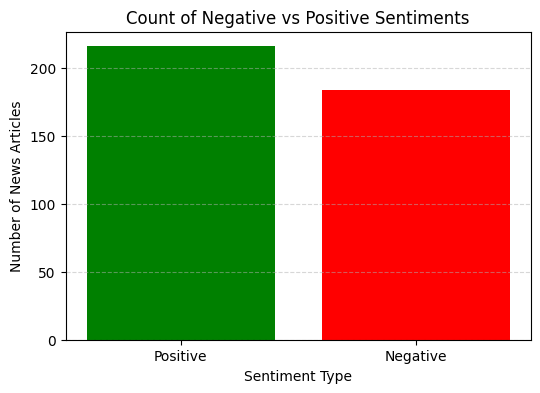

In [16]:
counts = df["Final Status"].value_counts()
# Plot
plt.figure(figsize=(6, 4))
plt.bar(counts.index.map({0: "Negative", 1: "Positive"}), counts.values, color=['green', 'red'])
plt.title("Count of Negative vs Positive Sentiments")
plt.xlabel("Sentiment Type")
plt.ylabel("Number of News Articles")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [17]:
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Keep letters only
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)

# Assuming df is already defined as a pandas DataFrame
df['clean_text'] = df['Full_text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [19]:
df.head()

,Full_text,Final Status,clean_text
0,ReutersPayments companies and banks are at log...,0,reuterspayments company bank loggerhead sharin...
1,AgenciesThe bank presently has 20 million acti...,1,agenciesthe bank presently million active user...
2,PTIKarnataka Chief Minister Basavaraj Bommai.K...,1,ptikarnataka chief minister basavaraj bommai k...
3,Getty ImagesThe budget for FY22 had imposed in...,0,getty imagesthe budget fy imposed income tax i...
4,AgenciesThere is a view in the insurance indus...,1,agenciesthere view insurance industry iib able...


In [20]:
from sklearn.model_selection import train_test_split,GridSearchCV
# Train-Test Split
X = df['clean_text']
y = df['Final Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [22]:
# Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [23]:
smote = SMOTE(random_state=42)
X_train_bow, y_train = smote.fit_resample(X_train_bow, y_train)

In [24]:
# Random Forest
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train_bow, y_train)
pred_rf = rf.predict(X_test_bow)
print("Random Forest (BoW):\n", classification_report(y_test, pred_rf))

Random Forest (BoW):
               precision    recall  f1-score   support

           0       0.68      0.65      0.67        40
           1       0.67      0.70      0.68        40

    accuracy                           0.68        80
   macro avg       0.68      0.68      0.67        80
weighted avg       0.68      0.68      0.67        80



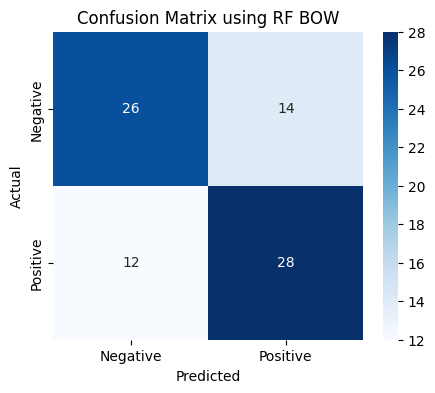

In [81]:
cm = confusion_matrix(y_test, pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using RF BOW")
plt.show()

In [38]:
# XGBoost
xgb = XGBClassifier(n_estimators = 300, eval_metric='logloss')
xgb.fit(X_train_bow, y_train)
pred_xgb = xgb.predict(X_test_bow)
print("XGBoost (BoW):\n", classification_report(y_test, pred_xgb))

XGBoost (BoW):
               precision    recall  f1-score   support

           0       0.74      0.57      0.65        40
           1       0.65      0.80      0.72        40

    accuracy                           0.69        80
   macro avg       0.70      0.69      0.68        80
weighted avg       0.70      0.69      0.68        80



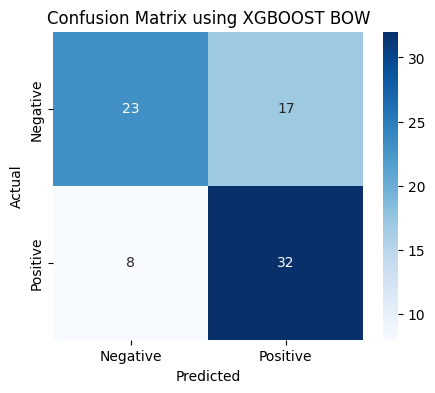

In [80]:
cm = confusion_matrix(y_test, pred_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using XGBOOST BOW")
plt.show()

In [29]:
# AdaBoost
ada = AdaBoostClassifier(n_estimators= 300)
ada.fit(X_train_bow, y_train)
pred_ada = ada.predict(X_test_bow)
print("AdaBoost (BoW):\n", classification_report(y_test, pred_ada))

AdaBoost (BoW):
               precision    recall  f1-score   support

           0       0.74      0.70      0.72        40
           1       0.71      0.75      0.73        40

    accuracy                           0.72        80
   macro avg       0.73      0.72      0.72        80
weighted avg       0.73      0.72      0.72        80



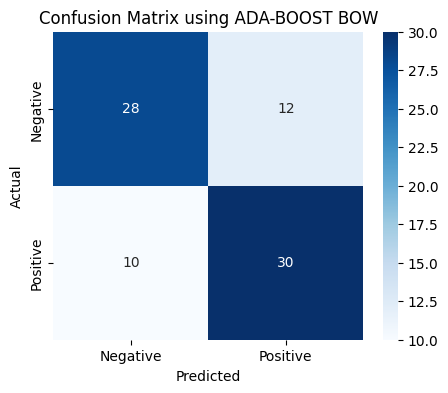

In [79]:
cm = confusion_matrix(y_test, pred_ada)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using ADA-BOOST BOW")
plt.show()

In [30]:
# Train-Test Split
X = df['clean_text']
y = df['Final Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [32]:
smote = SMOTE(random_state=42)
X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)

In [33]:
# Random Forest
rf = RandomForestClassifier(n_estimators= 300)
rf.fit(X_train_tfidf, y_train)
pred_rf_tfidf = rf.predict(X_test_tfidf)
print("Random Forest (TF-IDF):\n", classification_report(y_test, pred_rf_tfidf))

Random Forest (TF-IDF):
               precision    recall  f1-score   support

           0       0.64      0.53      0.58        40
           1       0.60      0.70      0.64        40

    accuracy                           0.61        80
   macro avg       0.62      0.61      0.61        80
weighted avg       0.62      0.61      0.61        80



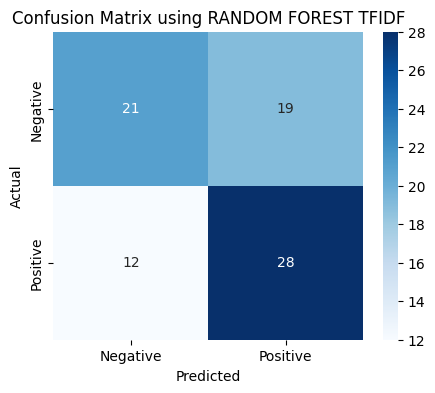

In [78]:
cm = confusion_matrix(y_test, pred_rf_tfidf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using RANDOM FOREST TFIDF")
plt.show()

In [39]:
# XGBoost
xgb = XGBClassifier(n_estimators = 300, eval_metric='logloss')
xgb.fit(X_train_tfidf, y_train)
pred_xg_tfidf = rf.predict(X_test_tfidf)
print("XGBoost (TF-IDF):\n", classification_report(y_test, pred_xg_tfidf))

XGBoost (TF-IDF):
               precision    recall  f1-score   support

           0       0.64      0.53      0.58        40
           1       0.60      0.70      0.64        40

    accuracy                           0.61        80
   macro avg       0.62      0.61      0.61        80
weighted avg       0.62      0.61      0.61        80



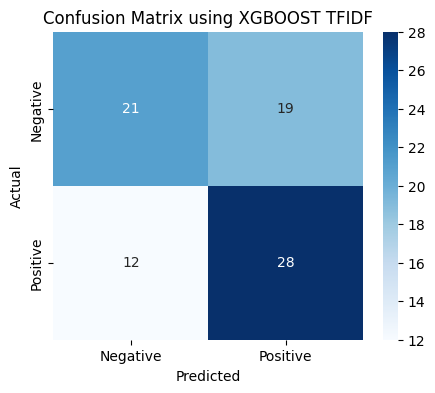

In [77]:
cm = confusion_matrix(y_test, pred_xg_tfidf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using XGBOOST TFIDF")
plt.show()

In [40]:
# AdaBoost
ada = AdaBoostClassifier(n_estimators= 400)
ada.fit(X_train_tfidf, y_train)
pred_ada_tfidf = rf.predict(X_test_tfidf)
print("AdaBoost (TF-IDF):\n", classification_report(y_test, pred_ada_tfidf))

AdaBoost (TF-IDF):
               precision    recall  f1-score   support

           0       0.64      0.53      0.58        40
           1       0.60      0.70      0.64        40

    accuracy                           0.61        80
   macro avg       0.62      0.61      0.61        80
weighted avg       0.62      0.61      0.61        80



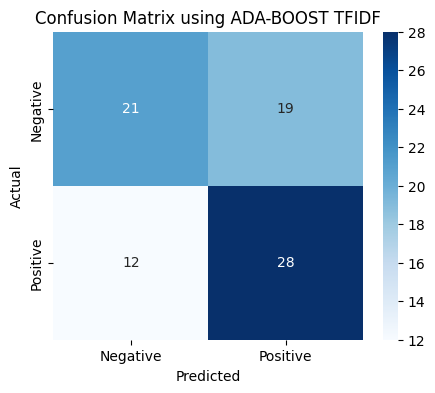

In [76]:
cm = confusion_matrix(y_test, pred_ada_tfidf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using ADA-BOOST TFIDF")
plt.show()

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU

In [59]:
# Tokenization
max_words = 10000  # Vocabulary size
max_len = 128     # Max length of a comment

tokenizer = Tokenizer(num_words=max_words, oov_token="")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Final Status'], test_size=0.2, random_state=42)

In [60]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Assuming y_train contains binary labels (0 and 1)
classes = np.unique(y_train)  # Unique class labels
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
# Convert to dictionary format for model.fit()
class_weight_dict = {i: class_weights[i] for i in range(len(classes))}

In [61]:
# Build LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification (positive/negative)
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 128, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,168,769 (4.46 MB)

 Trainable params: 1,168,769 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, class_weight = class_weight_dict)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 632ms/step - accuracy: 0.4611 - loss: 0.6940 - val_accuracy: 0.5875 - val_loss: 0.6910
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.6405 - loss: 0.6901 - val_accuracy: 0.6250 - val_loss: 0.6875
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.7849 - loss: 0.6735 - val_accuracy: 0.6125 - val_loss: 0.6689
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 751ms/step - accuracy: 0.7514 - loss: 0.6066 - val_accuracy: 0.6125 - val_loss: 0.7328
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - accuracy: 0.7470 - loss: 0.4839 - val_accuracy: 0.6250 - val_loss: 0.6481
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.8091 - loss: 0.4853 - val_accuracy: 0.6250 - val_loss: 0.6603
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.8193 - loss: 0.4447 - val_accuracy: 0.7125 - val_loss: 0.6665
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.8624 - loss: 0.3237 - val_accuracy: 0.6625 - val_loss:

In [63]:
y_pred_lstm = model.predict(X_test)
y_pred_lstm = np.where(y_pred_lstm > 0.5, 1, 0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step


In [64]:
print(classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64        40
           1       0.64      0.68      0.66        40

    accuracy                           0.65        80
   macro avg       0.65      0.65      0.65        80
weighted avg       0.65      0.65      0.65        80



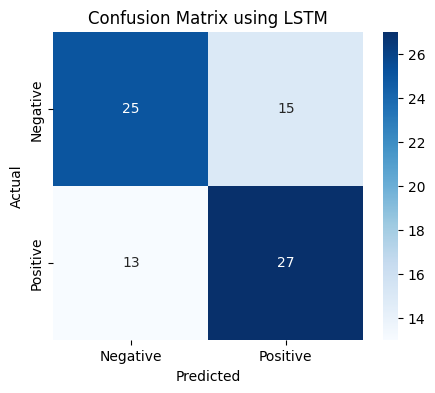

In [75]:
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using LSTM")
plt.show()

In [65]:

model = Sequential([Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
                    Bidirectional(LSTM(units=128, return_sequences=False)),
                    Dense(1, activation='sigmoid')])
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 128, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,234,753 (4.71 MB)

 Trainable params: 1,234,753 (4.71 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, class_weight=class_weight_dict)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 818ms/step - accuracy: 0.4864 - loss: 0.6983 - val_accuracy: 0.5000 - val_loss: 0.6905
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - accuracy: 0.4781 - loss: 0.6835 - val_accuracy: 0.5750 - val_loss: 0.6888
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 560ms/step - accuracy: 0.7918 - loss: 0.6674 - val_accuracy: 0.5750 - val_loss: 0.6823
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 878ms/step - accuracy: 0.8181 - loss: 0.6007 - val_accuracy: 0.6375 - val_loss: 0.6635
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - accuracy: 0.7872 - loss: 0.4778 - val_accuracy: 0.5750 - val_loss: 0.6664
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 578ms/step - accuracy: 0.8717 - loss: 0.3422 - val_accuracy: 0.6250 - val_loss: 0.6793
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 613ms/step - accuracy: 0.9115 - loss: 0.2693 - val_accuracy: 0.5750 - val_loss: 0.6923
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.9129 - loss: 0.2420 - val_accuracy: 0.6000 - val_loss:

In [67]:
y_pred_bi = model.predict(X_test)
y_pred_bi = np.where(y_pred_bi > 0.5, 1, 0)

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 581ms/step


In [68]:
print(classification_report(y_test, y_pred_bi))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        40
           1       0.70      0.82      0.76        40

    accuracy                           0.74        80
   macro avg       0.75      0.74      0.74        80
weighted avg       0.75      0.74      0.74        80



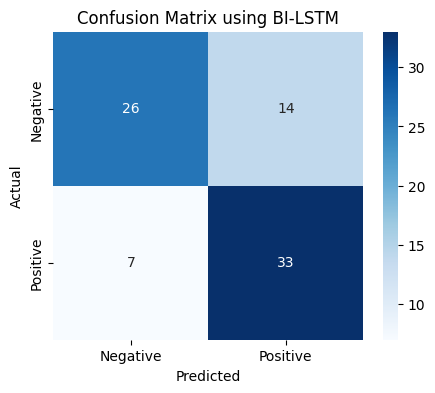

In [74]:
cm = confusion_matrix(y_test, y_pred_bi)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using BI-LSTM")
plt.show()

In [69]:
#GRU-LSTM
model = Sequential([Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
                    GRU(units=128, return_sequences=True),
                    LSTM(units=64, return_sequences=False),
                    Dropout(0.5),
                    Dense(1, activation='sigmoid')
])
# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and summary
model.build((None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 128, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128, 128)            │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,137,793 (4.34 MB)

 Trainable params: 1,137,793 (4.34 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, class_weight=class_weight_dict)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 790ms/step - accuracy: 0.5114 - loss: 0.6908 - val_accuracy: 0.5500 - val_loss: 0.6920
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - accuracy: 0.6433 - loss: 0.6870 - val_accuracy: 0.5125 - val_loss: 0.6880
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step - accuracy: 0.6981 - loss: 0.6831 - val_accuracy: 0.6250 - val_loss: 0.6823
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - accuracy: 0.7527 - loss: 0.6639 - val_accuracy: 0.6250 - val_loss: 0.6710
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.7778 - loss: 0.6041 - val_accuracy: 0.6500 - val_loss: 0.6552
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 496ms/step - accuracy: 0.8068 - loss: 0.4496 - val_accuracy: 0.5875 - val_loss: 0.7131
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - accuracy: 0.8453 - loss: 0.3344 - val_accuracy: 0.6375 - val_loss: 0.6876
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step - accuracy: 0.8944 - loss: 0.2762 - val_accuracy: 0.6000 - val_loss:

In [71]:
y_pred_gru = model.predict(X_test)
y_pred_gru = np.where(y_pred_gru > 0.5, 1, 0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step


In [72]:
print(classification_report(y_test, y_pred_gru))

              precision    recall  f1-score   support

           0       0.71      0.55      0.62        40
           1       0.63      0.78      0.70        40

    accuracy                           0.66        80
   macro avg       0.67      0.66      0.66        80
weighted avg       0.67      0.66      0.66        80



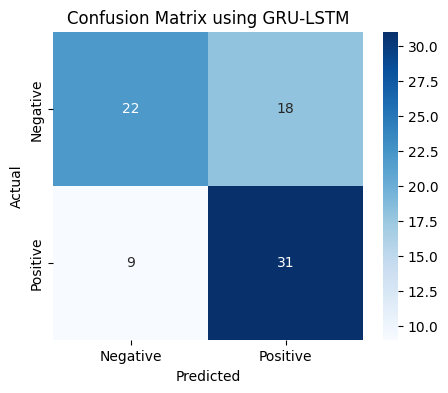

In [73]:
cm = confusion_matrix(y_test, y_pred_gru)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using GRU-LSTM")
plt.show()

In [82]:
# Calculate accuracy for each model
acc_rf = accuracy_score(y_test, pred_rf)
acc_xgb = accuracy_score(y_test, pred_xgb)
acc_ada = accuracy_score(y_test, pred_ada)
acc_rf_tfidf = accuracy_score(y_test, pred_rf_tfidf)
acc_xg_tfidf = accuracy_score(y_test, pred_xg_tfidf)
acc_ada_tfidf = accuracy_score(y_test, pred_ada_tfidf)
acc_lstm = accuracy_score(y_test, y_pred_lstm)
acc_bi = accuracy_score(y_test, y_pred_bi)
acc_gru = accuracy_score(y_test, y_pred_gru)

<ipython-input-83-f45de96dc1c0>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='viridis')


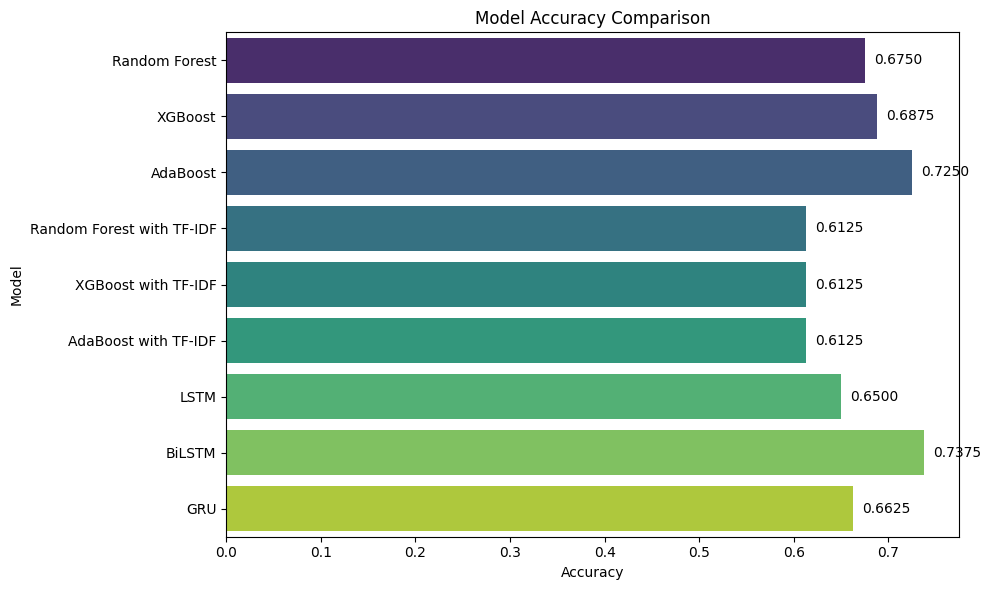

In [83]:
# Create a dictionary with model names and corresponding accuracy values
accuracy_dict = {
    'Random Forest': acc_rf,
    'XGBoost': acc_xgb,
    'AdaBoost': acc_ada,
    'Random Forest with TF-IDF': acc_rf_tfidf,
    'XGBoost with TF-IDF': acc_xg_tfidf,
    'AdaBoost with TF-IDF': acc_ada_tfidf,
    'LSTM': acc_lstm,
    'BiLSTM': acc_bi,
    'GRU': acc_gru
}
# Convert dictionary to DataFrame for easy plotting
accuracy_df = pd.DataFrame(list(accuracy_dict.items()), columns=['Model', 'Accuracy'])
# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='viridis')
# Add the accuracy values on top of the bars
for index, value in enumerate(accuracy_df['Accuracy']):
    plt.text(value + 0.01, index, f'{value:.4f}', va='center')
# Set labels and title
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Accuracy Comparison')
# Show the plot
plt.tight_layout()
plt.show()

In [84]:
from sklearn.metrics import precision_score

In [85]:
# precision score
precision_rf = precision_score(y_test, pred_rf)
precision_xgb = precision_score(y_test, pred_xgb)
precision_ada = precision_score(y_test, pred_ada)
precision_rf_tfidf = precision_score(y_test, pred_rf_tfidf)
precision_xg_tfidf = precision_score(y_test, pred_xg_tfidf)
precision_ada_tfidf = precision_score(y_test, pred_ada_tfidf)
precision_lstm = precision_score(y_test, y_pred_lstm)
precision_bi = precision_score(y_test, y_pred_bi)
precision_gru = precision_score(y_test, y_pred_gru)

<ipython-input-92-3ae698ab2932>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_precision, x="Model", y="Precision", palette="Blues_d")  # Use a color palette


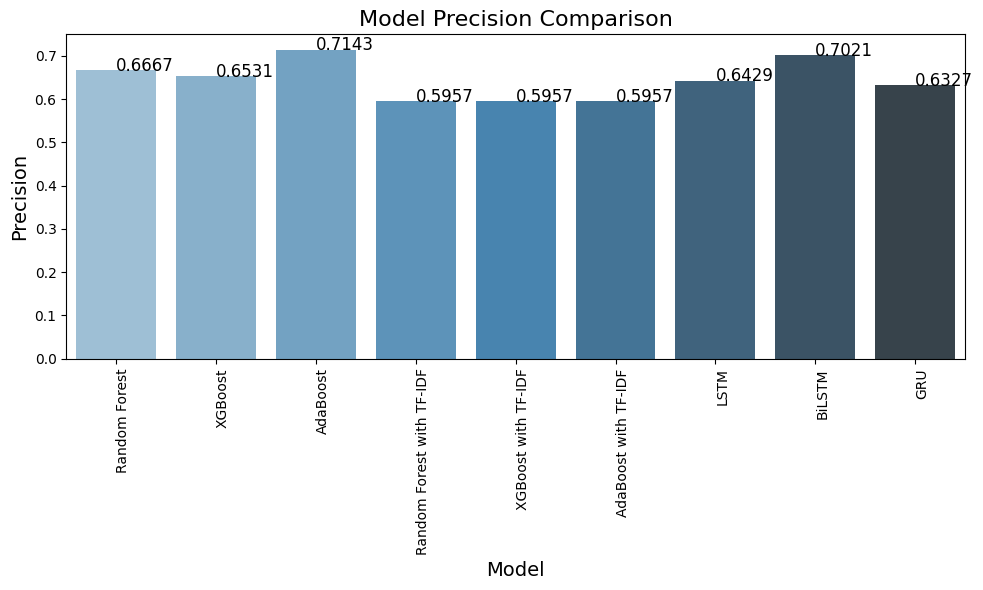

In [92]:
# Precision values from the models
precisions = {
    "Random Forest": precision_rf,
    "XGBoost": precision_xgb,
    "AdaBoost": precision_ada,
    "Random Forest with TF-IDF": precision_rf_tfidf,
    "XGBoost with TF-IDF": precision_xg_tfidf,
    "AdaBoost with TF-IDF": precision_ada_tfidf,
    "LSTM": precision_lstm,
    "BiLSTM": precision_bi,
    "GRU": precision_gru
}
# Convert the dictionary into a pandas DataFrame
df_precision = pd.DataFrame(list(precisions.items()), columns=["Model", "Precision"])
# Create the barplot for precision
plt.figure(figsize=(10, 6))  # Set figure size for better visibility
sns.barplot(data=df_precision, x="Model", y="Precision", palette="Blues_d")  # Use a color palette
# Add value annotations on top of each bar
for index, value in enumerate(df_precision['Precision']):
    plt.text(index, value + 0.01, f"{value:.4f}", va='center', fontsize=12)
# Add titles and labels
plt.title("Model Precision Comparison", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.xticks(rotation=90, ha="left")  # Rotate x-axis labels for better readability
# Display the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()